In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%cd /content/drive/MyDrive/MyPython/ProbSpace/src

/content/drive/MyDrive/MyPython/ProbSpace/src


In [13]:
!pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# Library
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import lightgbm as lgb
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from sklearn.feature_selection import RFE
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction
from tqdm.auto import tqdm

import warnings
warnings.simplefilter('ignore')

In [15]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
seed = 42

In [16]:
train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')
submission_df = pd.read_csv('../data/submission.csv')

In [17]:
test_df.tail()

,id,date,highest,lowest,rain
16,17,4/12,12.6,7.5,0.0
17,18,4/13,18.2,5.5,0.0
18,19,4/14,18.3,9.7,0.0
19,20,4/15,22.7,11.6,5.0
20,21,4/16,21.0,10.1,0.0


In [18]:
def preprocessing(df, mode='train'):
    df_tmp = df.copy()
    input_year = 2021

    df_tmp['time'] = pd.to_datetime(df_tmp.date, format='%m/%d')
    df_tmp['year'] = df_tmp['time'].dt.year
    df_tmp['month'] = df_tmp['time'].dt.month
    df_tmp['day'] = df_tmp['time'].dt.day
    if mode=='train':
        df_tmp.loc[df_tmp['month']>3, 'year'] = input_year
        df_tmp.loc[df_tmp['month']<=3, 'year'] = input_year + 1
    else:
        df_tmp['year'] = input_year + 1
    df_tmp['time'] = pd.to_datetime({'year':df_tmp.year, 'month':df_tmp.month, 'day':df_tmp.day})
    df_tmp['weekday'] = df_tmp['time'].dt.weekday
    return df_tmp

train_df = preprocessing(train_df, mode='train')
test_df = preprocessing(test_df, mode='test')

In [19]:
train_df.columns

Index(['id', 'date', 'highest', 'lowest', 'rain', 'ice1', 'ice2', 'ice3',
       'oden1', 'oden2', 'oden3', 'oden4', 'hot1', 'hot2', 'hot3', 'dessert1',
       'dessert2', 'dessert3', 'dessert4', 'dessert5', 'drink1', 'drink2',
       'drink3', 'drink4', 'drink5', 'drink6', 'alcol1', 'alcol2', 'alcol3',
       'snack1', 'snack2', 'snack3', 'bento1', 'bento2', 'bento3', 'bento4',
       'tild1', 'tild2', 'men1', 'men2', 'men3', 'men4', 'men5', 'men6',
       'time', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [20]:
target_columns = ['ice1', 'ice2', 'ice3',
    'oden1', 'oden2', 'oden3', 'oden4', 'hot1', 'hot2', 'hot3', 'dessert1',
    'dessert2', 'dessert3', 'dessert4', 'dessert5', 'drink1', 'drink2',
    'drink3', 'drink4', 'drink5', 'drink6', 'alcol1', 'alcol2', 'alcol3',
    'snack1', 'snack2', 'snack3', 'bento1', 'bento2', 'bento3', 'bento4',
    'tild1', 'tild2', 'men1', 'men2', 'men3', 'men4', 'men5', 'men6']

In [21]:
all_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

Text(0.5, 0.98, 'Cyclical encoding with sine/cosine transformation')

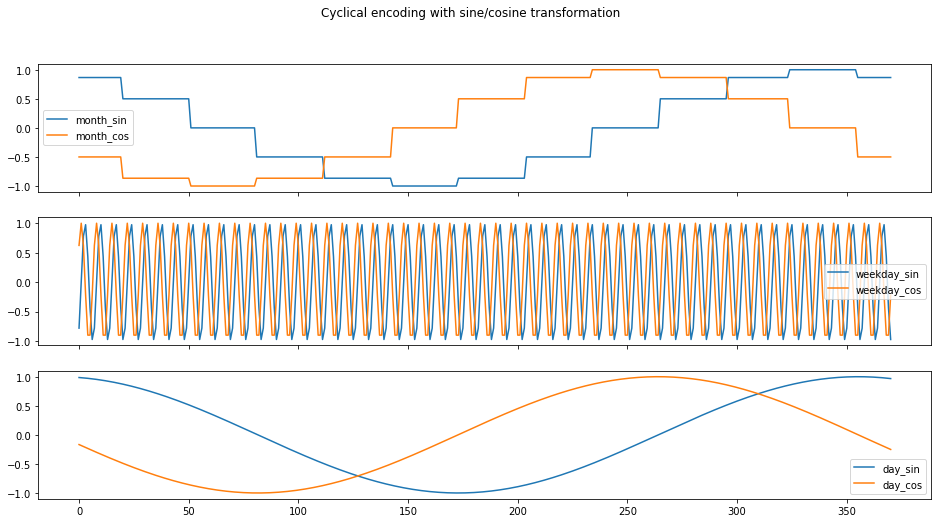

In [22]:
# sin,cos変換を適用
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

all_df_sincos = all_df.copy()
all_df_sincos['day_of_year'] = all_df.time.dt.day_of_year

# month -> sin, cos
all_df_sincos['month_sin'] = sin_transformer(12).fit_transform(all_df_sincos['month'])
all_df_sincos['month_cos'] = cos_transformer(12).fit_transform(all_df_sincos['month'])

# week -> sin, cos
all_df_sincos['weekday_sin'] = sin_transformer(7).fit_transform(all_df_sincos['weekday'])
all_df_sincos['weekday_cos'] = cos_transformer(7).fit_transform(all_df_sincos['weekday'])

# day -> sin, cos
all_df_sincos['day_sin'] = sin_transformer(365).fit_transform(all_df_sincos['day_of_year'])
all_df_sincos['day_cos'] = cos_transformer(365).fit_transform(all_df_sincos['day_of_year'])


fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16,8))
all_df_sincos[["month_sin", "month_cos"]].plot(ax=ax[0])
all_df_sincos[["weekday_sin", "weekday_cos"]].plot(ax=ax[1])
all_df_sincos[["day_sin", "day_cos"]].plot(ax=ax[2])
plt.suptitle("Cyclical encoding with sine/cosine transformation")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f14e332f390>,
      dtype=object)

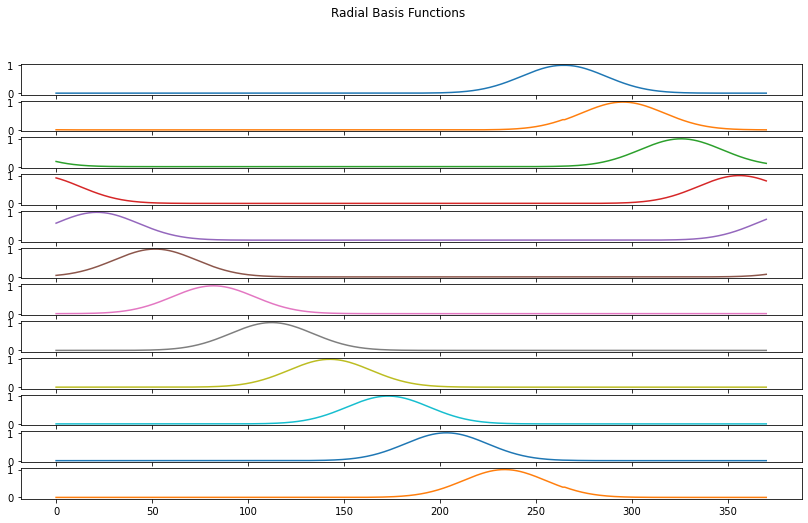

In [23]:
# 放射状基底関数
all_df_sincos_rbf = all_df_sincos.copy()

rbf = RepeatingBasisFunction(n_periods=12, column='day_of_year', input_range=(1, 365), remainder='drop')
rbf.fit(all_df_sincos_rbf)

tmp_column = [f'month_rbf_{i}' for i in range(1, 13)]
day_of_year_rbf = pd.DataFrame(columns=tmp_column, data=rbf.transform(all_df_sincos_rbf))

# 放射状基底関数を結合
all_df_sincos_rbf = pd.merge(all_df_sincos_rbf, day_of_year_rbf, left_index=True, right_index=True)

# プロット
day_of_year_rbf.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False)

In [24]:
all_df_sincos_rbf.head()

,id,date,highest,lowest,rain,ice1,ice2,ice3,oden1,oden2,oden3,oden4,hot1,hot2,hot3,dessert1,dessert2,dessert3,dessert4,dessert5,drink1,drink2,drink3,drink4,drink5,drink6,alcol1,alcol2,alcol3,snack1,snack2,snack3,bento1,bento2,bento3,bento4,tild1,tild2,men1,men2,men3,men4,men5,men6,time,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
0,1,4/11,21.9,12.4,0.0,25.0,72.0,26.0,10.0,23.0,52.0,35.0,180.0,254.0,270.0,42.0,58.0,50.0,59.0,67.0,54.0,45.0,28.0,49.0,22.0,8.0,63.0,51.0,59.0,26.0,21.0,35.0,56.0,46.0,70.0,27.0,12.0,12.0,57.0,30.0,41.0,38.0,37.0,35.0,2021-04-11,2021,4,11,6,101,0.866025,-0.5,-0.781831,0.623490,0.985948,-0.167052,0.000019,0.005119,0.186106,0.915731,0.609799,0.054956,0.000670,0.000001,2.471564e-10,7.472152e-15,6.543946e-13,9.598498e-09
1,2,4/12,25.9,13.9,0.0,30.0,85.0,33.0,9.0,18.0,42.0,26.0,202.0,219.0,235.0,22.0,36.0,5.0,28.0,37.0,69.0,54.0,35.0,58.0,22.0,9.0,77.0,66.0,72.0,36.0,32.0,63.0,8.0,14.0,23.0,9.0,5.0,8.0,19.0,9.0,13.0,26.0,4.0,16.0,2021-04-12,2021,4,12,0,102,0.866025,-0.5,0.000000,1.000000,0.982927,-0.183998,0.000015,0.004395,0.170670,0.897015,0.638048,0.061421,0.000800,0.000001,3.366494e-10,1.087143e-14,4.609966e-13,7.222641e-09
2,3,4/13,20.9,11.9,0.0,21.0,68.0,28.0,12.0,22.0,57.0,31.0,164.0,210.0,223.0,20.0,41.0,5.0,30.0,32.0,46.0,38.0,24.0,45.0,26.0,9.0,81.0,69.0,74.0,36.0,25.0,57.0,9.0,12.0,19.0,6.0,4.0,9.0,23.0,9.0,11.0,33.0,4.0,13.0,2021-04-13,2021,4,13,1,103,0.866025,-0.5,0.781831,0.623490,0.979614,-0.200891,0.000012,0.003765,0.156175,0.876774,0.666156,0.068498,0.000953,0.000002,4.575512e-10,1.578277e-14,3.240497e-13,5.423065e-09
3,4,4/14,18.8,11.4,0.0,19.0,62.0,35.0,13.0,29.0,62.0,33.0,193.0,242.0,251.0,21.0,43.0,5.0,28.0,32.0,35.0,31.0,22.0,37.0,23.0,8.0,88.0,92.0,81.0,20.0,10.0,45.0,54.0,43.0,74.0,28.0,15.0,17.0,55.0,35.0,46.0,46.0,51.0,46.0,2021-04-14,2021,4,14,2,104,0.866025,-0.5,0.974928,-0.222521,0.976011,-0.217723,0.000010,0.003218,0.142600,0.855129,0.693993,0.076224,0.001133,0.000002,6.205227e-10,2.286315e-14,2.272907e-13,4.063025e-09
4,5,4/15,22.1,13.5,19.0,21.0,72.0,32.0,10.0,24.0,44.0,33.0,218.0,271.0,274.0,44.0,63.0,47.0,59.0,63.0,51.0,39.0,20.0,52.0,28.0,14.0,116.0,135.0,119.0,31.0,21.0,39.0,52.0,36.0,69.0,26.0,4.0,9.0,54.0,33.0,39.0,40.0,41.0,40.0,2021-04-15,2021,4,15,3,105,0.866025,-0.5,0.433884,-0.900969,0.972118,-0.234491,0.000008,0.002745,0.129923,0.832208,0.721422,0.084637,0.001344,0.000003,8.397145e-10,3.304797e-14,1.590770e-13,3.037458e-09


In [25]:
# train, test に分ける
train_df_sincos_rbf = all_df_sincos_rbf.iloc[:350, :]
test_df_sincos_rbf = all_df_sincos_rbf.iloc[350:, :].dropna(axis=1)

In [26]:
# 検証データのindexを指定(訓練データの最後2ヶ月を使用)
valid_index = range(297,351) # month:2,3
# valid_index = range(325,351) # month:3

# 予測結果を保存する辞書型データ
results = dict({})
all_lgb_score = []

# 商品ごとの予測を作成

for c in tqdm(target_columns):
    train_tmp = train_df_sincos_rbf.copy()
    test_tmp = test_df_sincos_rbf.copy()
    
    #ice
    if c in ['ice1', 'ice2', 'ice3']:
        # 予測期間はアイスが人気な7, 8 ,9月ではないので除外
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        # アイスは金曜に人気
        train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
        test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
    # oden
    elif c in ['oden1', 'oden2', 'oden3', 'oden4']:
        # おでんやって無い夏は考えない
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        # おでんは水木で人気
        train_tmp['is_wday23'] = train_df['weekday'].isin([2, 3]).astype(int)
        test_tmp['is_wday23'] = test_df['weekday'].isin([2, 3]).astype(int)
    # hot
    elif c in ['hot1', 'hot2', 'hot3']:
        # ホットスナックは月、火、金で不人気
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    # dessert
    elif c in ['dessert1', 'dessert2', 'dessert3', 'dessert4', 'dessert5']:
        # デザートは水曜と日曜で人気
        train_tmp['is_wday36'] = train_df['weekday'].isin([3,6]).astype(int)
        test_tmp['is_wday36'] = test_df['weekday'].isin([3,6]).astype(int)
    # drink1234
    elif c in ['drink1', 'drink2', 'drink3', 'drink4']:
        # 夏に人気なドリンクは夏のデータは使わない
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        if c in ['drink1', 'drink4']:
            # 金曜に人気
            train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
            test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
        else:
            # 常に人気が変わらないドリンクは全期間つかう。火曜に人気
            train_tmp['is_wday1'] = train_df['weekday'].isin([1]).astype(int)
            test_tmp['is_wday1'] = test_df['weekday'].isin([1]).astype(int)
    # drink5
    elif c in ['drink5']:
        # 金曜に人気
        train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
        test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
    # drink6
    elif c in ['drink6']:
        # 日曜に人気
        train_tmp['is_wday6'] = train_df['weekday'].isin([6]).astype(int)
        test_tmp['is_wday6'] = test_df['weekday'].isin([6]).astype(int)
    # alcohol
    elif c in ['alcol1', 'alcol2', 'alcol3']:
        # 酒は水木で人気
        train_tmp['is_wday23'] = train_df['weekday'].isin([2, 3]).astype(int)
        test_tmp['is_wday23'] = test_df['weekday'].isin([2, 3]).astype(int)
    # snack
    elif c in ['snack1', 'snack2', 'snack3']:
        train_tmp['is_wday0'] = train_df['weekday'].isin([0]).astype(int)
        train_tmp['is_wday14'] = train_df['weekday'].isin([1,4]).astype(int)
        test_tmp['is_wday0'] = test_df['weekday'].isin([0]).astype(int)
        test_tmp['is_wday14'] = test_df['weekday'].isin([1,4]).astype(int)
    # bento
    elif c in ['bento1', 'bento2', 'bento3', 'bento4']:
        # 弁当は月、火、金で不人気
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    # tild
    elif c in ['tild1', 'tild2']:
        # 日曜に人気
        train_tmp['is_wday6'] = train_df['weekday'].isin([6]).astype(int)
        test_tmp['is_wday6'] = test_df['weekday'].isin([6]).astype(int)
    # men
    elif c in ['men1', 'men2', 'men3', 'men4', 'men5', 'men6']:
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    
    # 訓練に確実に不必要なデータを除く
    train_columns = [c for c in train_tmp.columns if c not in target_columns if c not in\
    # ['id', 'date', 'time', 'month', 'year', 'day', 'weekday', 'day_of_year']]
        ['id', 'date', 'time']]
    
    # データを訓練、検証に分割
    X_train = train_tmp[~train_tmp['id'].isin(valid_index)][train_columns]
    y_train = train_tmp[~train_tmp['id'].isin(valid_index)][c]
    X_valid = train_tmp[train_tmp['id'].isin(valid_index)][train_columns]
    y_valid = train_tmp[train_tmp['id'].isin(valid_index)][c]
     
    # テストデータ
    X_test = test_tmp[train_columns]

    # 分位点
    qs = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    
    # 分位点ごとのスコア
    q_scores = []
    
    # 分位点ごとにモデルを作成
    for q in qs:
        lgb = LGBMRegressor(
            objective='quantile',
            alpha = q,
            n_estimators=10000,
            colsample_bytree=0.9,
            random_state=seed,
            max_depth=5,
        )
        
        # RFEにより特徴量選択
        selector = RFE(lgb, n_features_to_select=0.6)
        selector.fit(X_train, y_train)
        
        # 特徴量が生き残ったか（残った：True、ドロップ：False）を表示
        result = pd.DataFrame(selector.get_support(), index=X_train.columns.values, columns=['left'])
        result['ranking'] = selector.ranking_
        print(f'---{c}_{q}---')
        display(result.T)
        print(' ')
        
        # このモデルで採用されたカラム
        train_columns_RFE = X_train.columns.values[selector.get_support()]
        
        # 採用されたカラムだけでデータを作成
        X_train_RFE = X_train[train_columns_RFE]
        X_valid_RFE = X_valid[train_columns_RFE]
        X_test_RFE = X_test[train_columns_RFE]
        
        
        # 学習
        lgb.fit(X_train_RFE, y_train, eval_set=(X_valid_RFE, y_valid), early_stopping_rounds=100, verbose=False)
        score = lgb.best_score_['valid_0']['quantile']
        
        y_pred = lgb.predict(X_test_RFE)
        results[(c, q)] = y_pred
        
        q_scores.append(score)

    all_lgb_score.append(q_scores)

score_df = pd.DataFrame(np.array(all_lgb_score), columns=qs, index=target_columns)
display(score_df)

print(f'ave score: {np.array(all_lgb_score).mean()}')

  0%|          | 0/39 [00:00<?, ?it/s]

---ice1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,4,1,1,1,1,1,3,7,9,11,1,1,1,1,1,1,1,1,2,5,6,8,10,12


 
---ice1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,3,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,8,5,7,9,4,6


 
---ice1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,1,5,4,7,6,3,10


 
---ice1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,1,5,4,10,6,3,7


 
---ice1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ranking,12,11,10,9,8,7,6,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


 
---ice2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,False,True,False,True,False,True,True,True,True,True,True,False,False,False,True,True,False
ranking,1,1,1,8,4,1,1,1,6,11,3,1,9,1,2,1,1,1,1,1,1,5,7,10,1,1,12


 
---ice2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,6,5,3,7,4,8


 
---ice2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,9,10,1,1,1,1,1,1,1,2,1,1,1,5,4,11,6,3,8


 
---ice2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,6,4,8,5,3,9


 
---ice2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,False,True,True,True,True,True,False,True,False,False,True,True,True,True,True,True,False,True,True,False,False,False,False,False,False
ranking,1,1,2,1,1,1,1,1,3,1,7,9,1,1,1,1,1,1,6,1,1,8,10,11,4,5,12


 
---ice3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,False,True,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,False,True,True,False,False,False,False,False
ranking,1,1,6,1,1,1,1,1,1,3,5,9,11,1,1,1,1,1,1,2,1,1,4,7,8,10,12


 
---ice3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,1,6,4,5,8,3,10


 
---ice3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,5,4,3,7,6,9


 
---ice3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,3,1,1,1,6,11,1,1,1,1,2,1,1,1,1,1,1,7,5,9,8,4,10


 
---ice3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,True,True,True,True,True,False,False,False,False,True,False,True,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,1,1,1,1,1,3,5,7,9,1,12,1,1,1,1,1,1,1,2,4,6,8,10,11


 
---oden1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,False,True,False,False,False,True,True,False,True,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,True,True,False
ranking,12,1,2,10,8,1,1,4,1,9,1,1,1,1,3,1,1,1,1,1,1,7,5,6,1,1,11


 
---oden1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,10,11,1,1,1,1,1,1,1,2,1,1,1,7,4,9,6,5,3


 
---oden1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,6,5,7,8,4,3


 
---oden1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,5,1,1,1,7,11,1,1,1,1,2,1,1,1,1,1,1,9,6,10,8,4,3


 
---oden1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,True,False
ranking,1,1,7,11,4,1,2,1,1,9,1,1,8,1,1,1,1,1,1,1,1,3,6,10,5,1,12


 
---oden2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,True,False,True,False,True,False,True,True,False,True,True,True,True,True,True,False,False,False,True,True,False
ranking,1,1,5,12,11,1,1,2,1,8,1,3,1,1,9,1,1,1,1,1,1,4,6,7,1,1,10


 
---oden2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,1,6,5,10,8,4,3


 
---oden2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,11,10,1,1,1,1,2,1,1,1,1,1,1,6,4,8,9,5,3


 
---oden2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,5,11,1,1,1,1,2,1,1,1,1,1,1,9,4,10,8,3,6


 
---oden2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,True,True,False,True,True,False,True,False,False,True,True,False
ranking,1,1,10,9,5,1,1,1,12,8,4,1,1,1,1,1,1,3,1,1,2,1,6,7,1,1,11


 
---oden3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,False,True,False,True,False,True,True,False,True,True,True,True,True,True,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,6,1,11,1,3,1,1,8,1,1,1,1,1,1,7,2,10,1,4,5


 
---oden3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,11,10,1,1,1,1,1,1,1,2,1,1,1,6,4,9,7,5,3


 
---oden3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,11,10,1,1,1,1,1,1,1,1,1,1,2,6,5,9,7,4,3


 
---oden3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,6,11,1,1,1,1,2,1,1,1,1,1,1,8,4,10,7,5,3


 
---oden3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,False,False,True,True,True,True,True,False,False,True,True,True,True,False,False,True,False
ranking,1,1,1,11,2,1,1,1,9,5,8,4,1,1,1,1,1,3,6,1,1,1,1,7,10,1,12


 
---oden4_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,False,False,True,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,True,False,False
ranking,1,1,1,12,11,1,3,4,1,10,1,1,1,1,7,1,1,1,1,1,1,8,9,6,1,5,2


 
---oden4_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,6,4,8,7,5,3


 
---oden4_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,2,1,1,1,1,1,1,6,5,7,8,4,3


 
---oden4_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,3,1,1,1,9,11,1,1,1,1,5,1,1,1,1,1,1,8,6,10,7,2,4


 
---oden4_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,False,True,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,True,True,False
ranking,1,1,10,9,2,1,3,1,12,8,1,1,1,1,1,1,1,4,1,1,1,5,6,7,1,1,11


 
---hot1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,False,False,True,True,True,True,True,False,True,True,False,True,False,False,False,True,True
ranking,1,1,1,12,9,1,1,1,3,11,7,6,1,1,1,1,1,8,1,1,10,1,2,5,4,1,1


 
---hot1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,3,1,1,5,2,7,8,4,1,6


 
---hot1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,3,1,1,4,1,1,8,1,7,5,2,1,6


 
---hot1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,8,11,1,1,1,1,1,1,1,4,1,1,9,3,5,7,1,2,6


 
---hot1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,False,True,True,True,False,True,False,False,False,True,True,True,True,False,False,False,True,True,True,False
ranking,1,1,1,12,10,1,1,3,1,1,1,6,1,2,7,11,1,1,1,1,9,8,4,1,1,1,5


 
---hot2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,False,True,True,True,True,True,True,False,True,True,False,True,True,False,False,False,False
ranking,1,1,1,12,4,1,1,1,7,11,5,1,1,1,1,1,1,3,1,1,10,1,1,9,2,8,6


 
---hot2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,8,2,7,5,3,1,6


 
---hot2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,1,1,1,4,1,1,5,2,8,6,3,1,7


 
---hot2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,2,1,1,4,1,1,6,1,8,7,3,1,5


 
---hot2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,False,True,False,True,False,True,True,False,False,True,True,True,True,True,False,False,False,True,True,False
ranking,1,1,1,12,10,1,1,4,1,11,1,5,1,1,6,2,1,1,1,1,1,7,9,3,1,1,8


 
---hot3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,False,False,True,True,True,True,True,False,False,True,False,True,False,False,True,True,True
ranking,1,1,1,12,6,1,1,1,3,11,4,2,1,1,1,1,1,9,5,1,7,1,8,10,1,1,1


 
---hot3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,False,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,2,1,6,3,7,8,1,1,5


 
---hot3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,11,1,1,1,10,9,1,1,1,1,3,1,1,2,1,1,7,1,8,6,4,1,5


 
---hot3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,8,11,1,1,1,1,1,1,1,4,1,1,9,3,7,5,1,2,6


 
---hot3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,False,True,True,True,False,True,True,False,True,False,True,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,2,1,1,1,4,1,1,10,1,6,1,1,1,7,3,11,5,1,1,8


 
---dessert1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,False,False,False,False,True,True,True,True,True,False,False,True,True,False,True,True,True,True,True,False,True,False,True,True,False,False
ranking,1,10,8,5,4,1,1,1,1,1,7,6,1,1,2,1,1,1,1,1,9,1,3,1,1,11,12


 
---dessert1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,True,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,6,1,7,5,3,2,8


 
---dessert1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,2,1,1,6,4,8,5,1,3,7


 
---dessert1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,11,9,1,1,1,1,1,1,1,2,1,1,6,4,5,8,3,1,7


 
---dessert1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,False,False,False,True,True,True,False,True,False,False,True,True,True,True,False,False,True,True,False,True,False,False,True,True,True
ranking,1,1,7,12,10,1,1,1,8,1,5,3,1,1,1,1,2,6,1,1,4,1,9,11,1,1,1


 
---dessert2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,False,True,False,False,True,False,True,True,False,True,True,True,True,True,True,True,False,False,False,True,False
ranking,1,1,1,12,9,1,5,1,8,10,1,6,1,1,3,1,1,1,1,1,1,1,7,4,2,1,11


 
---dessert2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,True,False,False,False,False,False
ranking,1,1,1,12,11,1,1,1,10,9,1,1,1,1,1,1,1,4,1,1,6,1,8,5,2,3,7


 
---dessert2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,3,1,1,4,1,1,6,2,8,5,1,1,7


 
---dessert2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,11,1,1,1,8,10,1,1,1,1,1,1,1,4,1,1,7,3,5,6,2,1,9


 
---dessert2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,False,False,False,True,False,False,True,True,False,False,True,True,False,True,True,True,True,True,False,True,True,False,False,True,True
ranking,1,1,3,12,11,1,2,4,1,1,6,5,1,1,7,1,1,1,1,1,9,1,1,10,8,1,1


 
---dessert3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,True,True,True,True,True,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,False,False,False
ranking,1,1,1,12,1,1,1,1,1,9,1,1,1,1,4,1,1,3,1,1,11,8,10,6,2,5,7


 
---dessert3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,False,True,True,True,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,2,1,1,1,1,1,4,1,1,6,1,8,5,3,1,7


 
---dessert3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,1,6,2,8,5,3,1,7


 
---dessert3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,1,7,3,6,8,2,1,5


 
---dessert3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,False,True,True,True,True,False,True,False,False,False,True,True
ranking,1,1,7,12,11,1,1,1,1,10,6,2,1,1,1,9,1,1,1,1,4,1,3,8,5,1,1


 
---dessert4_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,False,False,False,True,True,False,True,True,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False
ranking,1,1,6,4,3,1,1,2,1,1,5,9,11,1,1,1,1,1,1,1,1,1,1,7,8,10,12


 
---dessert4_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,1,8,2,6,5,1,3,7


 
---dessert4_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,False,True,True,True,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,2,1,1,1,1,1,3,1,1,5,4,7,6,1,1,8


 
---dessert4_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,10,1,1,1,8,11,1,1,1,1,2,1,1,4,1,1,9,3,5,6,1,1,7


 
---dessert4_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,True,True,False,False,True,False,True,False,True,False,True,True
ranking,1,1,4,12,10,1,1,1,1,3,7,2,1,1,1,1,1,11,6,1,9,1,8,1,5,1,1


 
---dessert5_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,False,False,False,True,True,True,False,False,True,False,True,True,False,True,True,True,True,True,False,False,False,True,True,True,False
ranking,1,1,3,12,9,1,1,1,5,6,1,8,1,1,4,1,1,1,1,1,10,2,7,1,1,1,11


 
---dessert5_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,1,1,1,4,1,1,7,3,5,6,2,1,8


 
---dessert5_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,2,1,1,4,1,1,6,3,8,5,1,1,7


 
---dessert5_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,1,7,2,5,8,3,1,6


 
---dessert5_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday36
left,True,True,True,False,False,True,False,True,True,False,True,False,False,True,True,True,True,False,True,True,False,False,False,False,True,True,True
ranking,1,1,1,12,10,1,2,1,1,11,1,3,5,1,1,1,1,7,1,1,6,4,8,9,1,1,1


 
---drink1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,False,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,True,False,False
ranking,1,1,1,12,9,1,2,1,11,10,1,1,1,1,3,1,1,1,1,1,1,8,6,7,1,5,4


 
---drink1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False
ranking,1,1,1,11,6,1,1,1,10,12,1,1,1,1,1,1,1,1,1,1,2,8,3,9,5,4,7


 
---drink1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,4,3,9,6,5,8


 
---drink1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,6,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,7,3,9,8,4,5


 
---drink1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,False,False,False,True,False,False,True,False,True,False,True,True,True,True,True,True,True,True,True,False,False,False,True,True,False
ranking,1,1,5,11,10,1,7,4,1,3,1,9,1,1,1,1,1,1,1,1,1,2,8,6,1,1,12


 
---drink2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,False,False,True,False,True,True,True,True,True,True,True,False,False,False,False,True,True,True,True,True,False,True,True,True,False,False,False
ranking,6,5,1,3,1,1,1,1,1,1,1,9,4,12,2,1,1,1,1,1,7,1,1,1,8,10,11


 
---drink2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,3,1,1,1,6,10,1,1,1,1,2,1,1,1,1,1,1,7,4,11,8,5,9


 
---drink2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,10,11,1,1,1,1,1,1,1,2,1,1,1,5,3,7,6,4,9


 
---drink2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,8,3,6,5,4,7


 
---drink2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,False,True,False,False,False,True,True,False,True,True,True,True,True,False,False,False,False,True,True,True
ranking,1,1,1,12,11,1,1,5,1,8,4,7,1,1,9,1,1,1,1,1,2,3,10,6,1,1,1


 
---drink3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,False,True,False,True,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,False,False,False,True,True,False,False
ranking,1,4,1,11,1,1,1,1,1,1,5,7,9,12,1,1,1,1,1,1,2,6,3,1,1,8,10


 
---drink3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,1,1,1,2,5,3,6,7,4,8


 
---drink3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,2,1,1,1,5,4,6,7,3,8


 
---drink3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,3,1,1,1,6,11,1,1,1,1,2,1,1,1,1,1,1,7,5,10,8,4,9


 
---drink3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday1
left,True,True,False,False,False,True,True,False,True,False,False,False,True,True,False,True,True,True,True,True,True,False,False,False,True,True,True
ranking,1,1,7,12,10,1,1,8,1,11,2,3,1,1,5,1,1,1,1,1,1,6,9,4,1,1,1


 
---drink4_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,False,True,False,True,True,True,True,True,False,True,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False
ranking,1,6,1,7,1,1,1,1,1,4,1,9,5,12,3,2,1,1,1,1,1,1,1,1,8,10,11


 
---drink4_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,3,1,1,1,6,10,1,1,1,1,2,1,1,1,1,1,1,7,5,11,8,4,9


 
---drink4_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,8,1,1,1,10,11,1,1,1,1,2,1,1,1,1,1,1,5,4,6,7,3,9


 
---drink4_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,12,7,1,1,1,8,11,1,1,1,1,2,1,1,1,1,1,1,5,3,10,6,4,9


 
---drink4_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,False,False,True,False,False,True,True,True,False,True,True,True,True,True,True,False,False,False,True,True,False
ranking,1,1,1,12,11,1,2,7,1,3,8,1,1,1,6,1,1,1,1,1,1,4,9,10,1,1,5


 
---drink5_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,False,False,False,True,True,True,True,False,True,False,True,True,False,True,True,True,True,True,False,False,False,False,True,True,False
ranking,1,1,10,12,7,1,1,1,1,8,1,4,1,1,6,1,1,1,1,1,2,3,5,9,1,1,11


 
---drink5_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,8,11,1,1,1,1,1,1,1,4,1,1,7,3,6,5,2,1,9


 
---drink5_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,3,1,1,4,1,1,7,1,6,5,2,1,8


 
---drink5_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,8,10,1,1,1,1,1,1,1,4,1,1,7,3,6,5,1,2,11


 
---drink5_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday4
left,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
ranking,1,1,1,1,1,1,1,1,3,5,7,9,11,12,10,8,6,4,2,1,1,1,1,1,1,1,1


 
---drink6_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,False,False,False,True,True,True,True,False,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False
ranking,1,1,10,12,7,1,1,1,1,9,4,5,1,1,2,1,1,6,1,1,8,1,1,3,1,1,11


 
---drink6_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,8,1,1,1,9,10,1,1,1,1,1,1,1,4,1,1,6,3,7,5,1,2,11


 
---drink6_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,10,8,1,1,1,1,3,1,1,1,1,1,5,4,7,6,1,2,11


 
---drink6_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,1,8,10,1,1,1,1,2,1,1,3,1,1,6,4,5,7,1,1,11


 
---drink6_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,True,True,True,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False
ranking,1,1,1,1,1,1,1,1,3,5,7,9,11,1,1,1,1,1,1,1,1,2,4,6,8,10,12


 
---alcol1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,False,False,True,False,True,False,False
ranking,1,1,3,11,8,1,1,1,2,9,1,1,1,12,1,1,1,1,1,1,4,6,1,5,1,7,10


 
---alcol1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,3,1,1,4,1,1,6,1,7,5,1,2,8


 
---alcol1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,3,1,1,1,1,1,7,4,5,6,1,2,8


 
---alcol1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,4,1,1,3,1,1,6,2,5,7,1,1,8


 
---alcol1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,False,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,True
ranking,1,1,1,12,8,1,1,1,9,11,4,1,1,1,7,1,1,5,1,1,10,2,3,6,1,1,1


 
---alcol2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,True,True,True,False,False,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False
ranking,1,1,3,10,5,1,1,1,1,7,2,1,11,12,8,6,4,1,1,1,1,1,1,1,1,1,9


 
---alcol2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,4,1,1,6,3,7,5,1,1,8


 
---alcol2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,3,1,1,4,1,1,5,1,6,7,2,1,8


 
---alcol2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,11,1,1,1,7,10,1,1,1,1,1,1,1,5,1,1,6,2,8,4,3,1,9


 
---alcol2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,False,True,True,False,False,True,True,False,True,True,False,True,True,False,False,True,True
ranking,1,1,1,12,6,1,1,1,8,11,4,1,1,7,5,1,1,9,1,1,10,1,1,2,3,1,1


 
---alcol3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,True,True,False,True,True,False,True,True,False,False,True,False
ranking,1,1,6,12,10,1,1,1,1,5,3,2,1,1,1,1,1,7,1,1,8,1,1,9,4,1,11


 
---alcol3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,7,2,6,5,1,3,8


 
---alcol3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,3,1,1,4,1,1,6,1,7,5,1,2,8


 
---alcol3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,1,7,3,6,5,2,1,8


 
---alcol3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday23
left,True,True,False,False,False,True,True,True,False,True,False,False,True,True,False,True,False,True,True,True,False,False,True,True,True,True,False
ranking,1,1,3,12,9,1,1,1,10,1,7,6,1,1,2,1,4,1,1,1,11,8,1,1,1,1,5


 
---snack1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,False,False,False,True,True,True,True,False,True,False,True,True,True,False,True,True,True,True,False,False,False,False,True,True,False,False
ranking,1,1,10,8,7,1,1,1,1,11,1,2,1,1,1,5,1,1,1,1,4,9,3,6,1,1,12,13


 
---snack1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False,False
ranking,1,1,1,13,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,7,2,6,5,1,3,12,8


 
---snack1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False,False
ranking,1,1,1,13,9,1,1,1,11,10,1,1,1,1,3,1,1,4,1,1,6,1,7,8,2,1,12,5


 
---snack1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,3,1,1,2,1,1,8,4,5,7,1,1,13,6


 
---snack1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,True,False,False,True,True,True,True,False,True,True,True,False,False,False,False,True,True,False,False
ranking,1,1,1,13,6,1,1,1,11,1,5,2,1,1,1,1,7,1,1,1,4,3,9,8,1,1,12,10


 
---snack2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,True,True,True,True,True,True,False,True,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False
ranking,1,1,1,1,1,1,1,1,1,5,1,9,8,1,1,1,1,1,1,2,3,4,6,7,10,11,12,13


 
---snack2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,3,1,1,2,1,1,8,4,5,6,1,1,13,7


 
---snack2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False,False
ranking,1,1,1,13,9,1,1,1,11,10,1,1,1,1,3,1,1,4,1,1,8,2,6,5,1,1,12,7


 
---snack2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False,False
ranking,1,1,1,13,10,1,1,1,9,11,1,1,1,1,2,1,1,4,1,1,6,3,5,8,1,1,12,7


 
---snack2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,False
ranking,13,12,11,10,9,5,4,3,2,1,1,1,1,1,1,7,8,1,1,1,1,1,1,1,1,1,1,6


 
---snack3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,False,False,False,True,False,True,True,False,True,False,True,True,False,True,True,True,True,True,False,True,True,False,True,False,False,False
ranking,1,1,8,11,9,1,5,1,1,6,1,7,1,1,3,1,1,1,1,1,10,1,1,4,1,2,12,13


 
---snack3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,4,1,1,7,3,8,5,1,1,13,6


 
---snack3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False,False
ranking,1,1,1,13,10,1,1,1,9,11,1,1,1,1,1,1,1,3,1,1,8,4,7,5,1,2,12,6


 
---snack3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,1,1,1,3,1,1,8,2,5,6,1,4,13,7


 
---snack3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday0,is_wday14
left,True,False,False,False,True,True,True,True,True,False,True,True,False,True,True,True,True,True,False,False,False,True,False,False,False,True,True,False
ranking,1,10,9,11,1,1,1,1,1,12,1,1,3,1,1,1,1,1,2,6,4,1,7,5,8,1,1,13


 
---bento1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,False,True,False,False,True,True,True,True,False,False,True,True,False,False,True,True,False,True,True,True,True,True,False,False,True,True
ranking,5,4,1,11,7,1,1,1,1,9,6,1,1,12,10,1,1,8,1,1,1,1,1,2,3,1,1


 
---bento1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,1,1,1,2,1,1,6,4,7,8,3,1,5


 
---bento1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,False,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,11,1,1,2,9,10,1,1,1,1,1,1,1,3,1,1,6,4,8,7,1,1,5


 
---bento1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,8,2,7,6,3,1,5


 
---bento1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,False,False,False,True,True,True,False,False,True,False,True,True,True,False,True,False,True,True,True,False,False,False,True,True,True
ranking,1,1,6,12,11,1,1,1,10,8,1,3,1,1,1,2,1,7,1,1,1,4,5,9,1,1,1


 
---bento2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,False,False,False,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,False,False,True,False,True,True,False
ranking,12,11,2,10,8,1,1,1,1,6,5,1,1,1,1,1,1,1,1,1,9,4,1,7,1,1,3


 
---bento2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,False,True,False,False,False,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,6,1,8,5,3,4,7


 
---bento2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,3,1,1,4,1,1,7,1,5,8,2,1,6


 
---bento2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,1,8,2,5,6,1,3,7


 
---bento2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,False,True,True,False,True,True,True,True,True,False,True,False,True,True,False,False,False,True,True,False,False
ranking,1,1,1,11,3,1,2,1,1,12,1,1,1,1,1,9,1,5,1,1,10,7,6,1,1,4,8


 
---bento3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,False,False,False,False,True,True,True,False,False,True,True,False,False,False,True,True,True,True,True,True,True,False,True,True,False
ranking,1,1,7,12,10,2,1,1,1,11,9,1,1,3,5,4,1,1,1,1,1,1,1,8,1,1,6


 
---bento3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,4,1,1,6,3,8,7,1,1,5


 
---bento3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,2,1,1,4,1,1,6,1,7,8,1,3,5


 
---bento3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,8,3,7,5,1,2,6


 
---bento3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,True,True,False,True,True,False,False,True,True,True,True,False,False,False,True,False,True,False
ranking,1,1,1,12,11,1,1,1,5,1,1,7,1,1,3,9,1,1,1,1,10,6,8,1,2,1,4


 
---bento4_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,False,True,False,False,True,True,False,False,True,True,True,True,False,False,True,True,True,True,True,False,True,False,False,True,True,True
ranking,5,4,1,9,8,1,1,7,11,1,1,1,1,12,10,1,1,1,1,1,6,1,2,3,1,1,1


 
---bento4_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,8,11,1,1,1,1,2,1,1,4,1,1,9,1,6,7,3,1,5


 
---bento4_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,4,1,1,1,1,1,8,2,6,7,3,1,5


 
---bento4_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,1,1,1,4,1,1,8,3,5,7,1,2,6


 
---bento4_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,False,False,False,True,True,True,False,False,True,False,True,True,True,True,False,True,True,False,False,True,True,False,True,True,False
ranking,1,1,3,12,11,1,1,1,10,9,1,7,1,1,1,1,2,1,1,5,8,1,1,6,1,1,4


 
---tild1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,False,False,False,True,True,True,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False
ranking,1,1,6,9,4,1,1,1,3,2,1,5,1,1,1,1,1,1,1,1,1,1,7,11,8,10,12


 
---tild1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,8,10,1,1,1,1,1,1,1,5,1,1,7,3,4,6,1,2,11


 
---tild1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,8,1,1,1,9,10,1,1,1,1,1,1,1,4,1,1,7,3,5,6,2,1,11


 
---tild1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,8,10,1,1,1,1,1,1,1,3,1,1,5,4,6,7,1,2,11


 
---tild1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,False,False,False,True,True,False,False,False,False,True,True,True,False,True,True,True,False,True,True,True,True,False,False,True,True
ranking,1,1,10,9,7,1,1,2,6,12,4,1,1,1,3,1,1,1,11,1,1,1,1,5,8,1,1


 
---tild2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,False,False,False,True,False,True,True,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,True,True,False
ranking,1,1,4,12,9,1,6,1,1,10,1,1,1,1,3,1,1,8,1,1,7,1,2,5,1,1,11


 
---tild2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,8,1,1,1,9,10,1,1,1,1,2,1,1,4,1,1,7,1,6,5,3,1,11


 
---tild2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,True,False,False
ranking,1,1,1,12,8,1,1,1,9,10,1,1,1,1,3,1,1,4,1,1,7,1,6,5,1,2,11


 
---tild2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,10,1,1,1,8,9,1,1,1,1,1,1,1,3,1,1,6,4,7,5,1,2,11


 
---tild2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday6
left,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ranking,12,11,10,9,8,7,6,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


 
---men1_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,False,False,True,True,False,True,True,True,True,True,False,True,False,False,True,True,False
ranking,1,1,1,12,11,1,1,1,9,10,6,2,1,1,4,1,1,1,1,1,8,1,3,5,1,1,7


 
---men1_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,8,3,7,6,2,1,5


 
---men1_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,2,1,1,4,1,1,8,3,7,5,1,1,6


 
---men1_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,10,1,1,1,11,9,1,1,1,1,2,1,1,3,1,1,5,4,8,6,1,1,7


 
---men1_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,False,False,False,False,False,False,True,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,False
ranking,1,4,6,12,10,3,2,1,1,11,1,1,1,1,1,1,1,8,1,1,9,1,1,1,1,5,7


 
---men2_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,True,True,False,False,True,True,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,False,True,False,False
ranking,5,1,1,12,9,1,1,4,7,8,2,1,1,11,1,1,1,1,1,1,1,1,1,10,1,3,6


 
---men2_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,2,1,1,4,1,1,7,1,8,6,3,1,5


 
---men2_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,False,False,False,True,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,4,1,1,2,1,1,6,3,8,7,1,1,5


 
---men2_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,6,3,5,8,1,2,7


 
---men2_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,False,False,False,True,False,False,True,True,True,True,True,False,False,True,True,True,True,True,True,False,False,False,True,True,False
ranking,1,1,9,11,8,1,3,6,1,1,1,1,1,5,4,1,1,1,1,1,1,2,7,10,1,1,12


 
---men3_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,False,False,True,True,False,True,True,False,True,True,False,True,True,True,False,True,False
ranking,1,1,1,12,9,1,1,1,5,11,10,3,1,1,8,1,1,7,1,1,4,1,1,1,2,1,6


 
---men3_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,3,1,1,4,1,1,8,1,6,7,2,1,5


 
---men3_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,False,False,True,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,4,1,2,6,1,7,8,3,1,5


 
---men3_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,1,1,1,3,1,1,6,4,7,8,2,1,5


 
---men3_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ranking,12,11,10,9,8,7,6,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


 
---men4_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False
ranking,12,1,1,1,1,1,1,1,1,3,5,6,9,11,10,1,1,1,1,1,1,1,1,2,4,7,8


 
---men4_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,7,2,8,6,3,1,5


 
---men4_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,10,11,1,1,1,1,1,1,1,4,1,1,8,2,7,6,3,1,5


 
---men4_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,7,4,6,8,3,1,5


 
---men4_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,False,False,False,True,True,False,True,False,True,True,True,False,False,False,False,True,True,True,True,True,True,True,True,False,False
ranking,1,1,2,11,12,1,1,10,1,6,1,1,1,7,9,8,5,1,1,1,1,1,1,1,1,3,4


 
---men5_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,True,False,False,False,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,False,True,False,False,True,True,False
ranking,7,1,2,12,10,1,1,1,1,9,6,1,1,1,1,1,3,1,1,1,11,1,4,8,1,1,5


 
---men5_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,1,1,1,5,1,1,8,3,6,7,1,2,4


 
---men5_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,11,9,1,1,1,1,4,1,1,2,1,1,7,1,8,6,3,1,5


 
---men5_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,10,1,1,1,9,11,1,1,1,1,2,1,1,1,1,1,8,4,5,6,3,1,7


 
---men5_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,False,False,False,True,True,True,True,False,True,False,True,True,False,True,True,False,True,True,True,False,False,False,True,True,False
ranking,1,1,4,12,9,1,1,1,1,5,1,2,1,1,8,1,1,3,1,1,1,10,11,7,1,1,6


 
---men6_0.01---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,True,True,False,True,True,False,False,False,False,False
ranking,1,1,1,12,11,1,1,1,8,10,1,1,1,1,7,1,1,1,1,2,1,1,3,9,4,5,6


 
---men6_0.1---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,2,1,1,4,1,1,8,1,7,6,3,1,5


 
---men6_0.5---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,True,False,False,False,False,False
ranking,1,1,1,12,9,1,1,1,11,10,1,1,1,1,1,1,1,4,1,1,6,1,8,7,2,3,5


 
---men6_0.9---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,True,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False
ranking,1,1,1,12,11,1,1,1,9,10,1,1,1,1,1,1,1,2,1,1,6,4,8,5,3,1,7


 
---men6_0.99---


,highest,lowest,rain,year,month,day,weekday,day_of_year,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,month_rbf_1,month_rbf_2,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,is_wday014
left,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ranking,12,11,10,9,8,7,6,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,0.01,0.10,0.50,0.90,0.99
ice1,0.060905,0.287129,0.780393,0.352219,0.695926
ice2,0.363385,1.068580,1.948731,0.467798,0.419630
ice3,0.070506,0.491150,1.180090,0.427386,0.257092
oden1,0.611076,1.607214,5.284758,2.490023,0.645114
oden2,0.578204,1.955276,5.860452,5.276919,3.847026
oden3,1.028167,2.643745,5.843441,5.198357,0.779599
oden4,0.589650,2.234531,4.243614,3.404247,0.743349
hot1,0.529771,2.196553,4.056772,1.864046,0.924023
hot2,0.399545,2.721673,6.017107,3.105409,0.564898
hot3,0.423050,2.145153,5.628970,2.606960,0.698523


ave score: 0.9504371257744294


In [27]:
submit_rows = [[f'{k[0]}_{k[1]}'] + v.tolist() for k, v in results.items()]

In [28]:
# submitファイルを作成
# データを整数に丸めることでわずかに精度が上がるらしい
submit_df = pd.DataFrame(np.array(submit_rows)[:, 1:22].astype(float).round(), index=np.array(submit_rows)[:, 0])
# 転置
submit_df = submit_df.transpose()
submit_df.index.name = 'id'
submit_df.to_csv("../work/submission/sub_lgb_kotrying_sincos_rbf_by_matsuyama_valid_23.csv")
display(submit_df.head())

,ice1_0.01,ice1_0.1,ice1_0.5,ice1_0.9,ice1_0.99,ice2_0.01,ice2_0.1,ice2_0.5,ice2_0.9,ice2_0.99,ice3_0.01,ice3_0.1,ice3_0.5,ice3_0.9,ice3_0.99,oden1_0.01,oden1_0.1,oden1_0.5,oden1_0.9,oden1_0.99,oden2_0.01,oden2_0.1,oden2_0.5,oden2_0.9,oden2_0.99,oden3_0.01,oden3_0.1,oden3_0.5,oden3_0.9,oden3_0.99,oden4_0.01,oden4_0.1,oden4_0.5,oden4_0.9,oden4_0.99,hot1_0.01,hot1_0.1,hot1_0.5,hot1_0.9,hot1_0.99,hot2_0.01,hot2_0.1,hot2_0.5,hot2_0.9,hot2_0.99,hot3_0.01,hot3_0.1,hot3_0.5,hot3_0.9,hot3_0.99,dessert1_0.01,dessert1_0.1,dessert1_0.5,dessert1_0.9,dessert1_0.99,dessert2_0.01,dessert2_0.1,dessert2_0.5,dessert2_0.9,dessert2_0.99,dessert3_0.01,dessert3_0.1,dessert3_0.5,dessert3_0.9,dessert3_0.99,dessert4_0.01,dessert4_0.1,dessert4_0.5,dessert4_0.9,dessert4_0.99,dessert5_0.01,dessert5_0.1,dessert5_0.5,dessert5_0.9,dessert5_0.99,drink1_0.01,drink1_0.1,drink1_0.5,drink1_0.9,drink1_0.99,drink2_0.01,drink2_0.1,drink2_0.5,drink2_0.9,drink2_0.99,drink3_0.01,drink3_0.1,drink3_0.5,drink3_0.9,drink3_0.99,drink4_0.01,drink4_0.1,drink4_0.5,drink4_0.9,drink4_0.99,drink5_0.01,drink5_0.1,drink5_0.5,drink5_0.9,drink5_0.99,drink6_0.01,drink6_0.1,drink6_0.5,drink6_0.9,drink6_0.99,alcol1_0.01,alcol1_0.1,alcol1_0.5,alcol1_0.9,alcol1_0.99,alcol2_0.01,alcol2_0.1,alcol2_0.5,alcol2_0.9,alcol2_0.99,alcol3_0.01,alcol3_0.1,alcol3_0.5,alcol3_0.9,alcol3_0.99,snack1_0.01,snack1_0.1,snack1_0.5,snack1_0.9,snack1_0.99,snack2_0.01,snack2_0.1,snack2_0.5,snack2_0.9,snack2_0.99,snack3_0.01,snack3_0.1,snack3_0.5,snack3_0.9,snack3_0.99,bento1_0.01,bento1_0.1,bento1_0.5,bento1_0.9,bento1_0.99,bento2_0.01,bento2_0.1,bento2_0.5,bento2_0.9,bento2_0.99,bento3_0.01,bento3_0.1,bento3_0.5,bento3_0.9,bento3_0.99,bento4_0.01,bento4_0.1,bento4_0.5,bento4_0.9,bento4_0.99,tild1_0.01,tild1_0.1,tild1_0.5,tild1_0.9,tild1_0.99,tild2_0.01,tild2_0.1,tild2_0.5,tild2_0.9,tild2_0.99,men1_0.01,men1_0.1,men1_0.5,men1_0.9,men1_0.99,men2_0.01,men2_0.1,men2_0.5,men2_0.9,men2_0.99,men3_0.01,men3_0.1,men3_0.5,men3_0.9,men3_0.99,men4_0.01,men4_0.1,men4_0.5,men4_0.9,men4_0.99,men5_0.01,men5_0.1,men5_0.5,men5_0.9,men5_0.99,men6_0.01,men6_0.1,men6_0.5,men6_0.9,men6_0.99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15.0,19.0,21.0,23.0,88.0,37.0,59.0,58.0,64.0,90.0,24.0,26.0,30.0,33.0,55.0,6.0,38.0,46.0,64.0,100.0,21.0,37.0,53.0,64.0,120.0,49.0,96.0,118.0,151.0,210.0,32.0,45.0,60.0,75.0,144.0,80.0,132.0,158.0,164.0,210.0,178.0,215.0,219.0,242.0,268.0,184.0,221.0,241.0,255.0,283.0,19.0,44.0,51.0,56.0,41.0,36.0,66.0,75.0,79.0,67.0,8.0,15.0,56.0,58.0,18.0,25.0,53.0,60.0,65.0,47.0,32.0,64.0,76.0,84.0,65.0,31.0,31.0,36.0,39.0,51.0,17.0,28.0,31.0,37.0,55.0,11.0,19.0,20.0,23.0,32.0,28.0,37.0,33.0,42.0,51.0,22.0,22.0,24.0,26.0,30.0,7.0,7.0,8.0,9.0,16.0,45.0,55.0,61.0,62.0,88.0,30.0,45.0,49.0,51.0,104.0,43.0,54.0,56.0,59.0,119.0,19.0,23.0,28.0,32.0,42.0,9.0,17.0,20.0,21.0,37.0,27.0,35.0,43.0,45.0,56.0,14.0,44.0,51.0,53.0,57.0,9.0,37.0,42.0,46.0,50.0,15.0,59.0,71.0,78.0,80.0,17.0,24.0,28.0,31.0,33.0,4.0,11.0,13.0,20.0,20.0,6.0,9.0,11.0,15.0,18.0,17.0,46.0,52.0,62.0,71.0,8.0,26.0,30.0,34.0,36.0,11.0,32.0,36.0,46.0,54.0,25.0,35.0,40.0,47.0,59.0,3.0,35.0,39.0,44.0,51.0,13.0,31.0,37.0,52.0,61.0
1,15.0,18.0,20.0,22.0,88.0,37.0,55.0,56.0,57.0,90.0,24.0,26.0,30.0,32.0,55.0,6.0,22.0,16.0,64.0,100.0,21.0,30.0,36.0,58.0,120.0,45.0,78.0,90.0,151.0,210.0,32.0,40.0,51.0,59.0,144.0,80.0,143.0,145.0,155.0,211.0,178.0,208.0,213.0,230.0,268.0,184.0,207.0,225.0,245.0,281.0,19.0,27.0,32.0,32.0,38.0,36.0,49.0,53.0,58.0,66.0,5.0,7.0,11.0,11.0,16.0,25.0,28.0,32.0,34.0,43.0,32.0,37.0,38.0,41.0,65.0,20.0,23.0,26.0,30.0,51.0,17.0,25.0,28.0,33.0,55.0,11.0,16.0,19.0,24.0,32.0,28.0,33.0,32.0,37.0,51.0,22.0,22.0,24.0,26.0,30.0,7.0,7.0,8.0,9.0,16.0,45.0,65.0,71.0,74.0,87.0,37.0,58.0,61.0,65.0,104.0,61.0,63.0,70.0,74.0,119.0,19.0,29.0,32.0,39.0,42.0,9.0,28.0,32.0,36.0,37.0,27.0,41.0,54.0,59.0,62.0,14

In [29]:
# 目視確認
pred_median_col = [c for c in submit_df.columns if '_0.5' in c]
test_add_pred = test_df.merge(submit_df[pred_median_col].reset_index(), on='id', how='left')
test_add_pred.columns = [c.replace('_0.5', '') if '_0.5' in c else c for c in test_add_pred.columns]
test_add_pred[target_columns] = test_add_pred[target_columns].astype(float)
test_add_pred.head(3)

,id,date,highest,lowest,rain,time,year,month,day,weekday,ice1,ice2,ice3,oden1,oden2,oden3,oden4,hot1,hot2,hot3,dessert1,dessert2,dessert3,dessert4,dessert5,drink1,drink2,drink3,drink4,drink5,drink6,alcol1,alcol2,alcol3,snack1,snack2,snack3,bento1,bento2,bento3,bento4,tild1,tild2,men1,men2,men3,men4,men5,men6
0,1,3/27,19.7,7.3,0.0,2022-03-27,2022,3,27,6,20.0,56.0,30.0,16.0,36.0,90.0,51.0,145.0,213.0,225.0,32.0,53.0,11.0,32.0,38.0,26.0,28.0,19.0,32.0,24.0,8.0,71.0,61.0,70.0,32.0,32.0,54.0,11.0,15.0,20.0,9.0,5.0,8.0,21.0,10.0,13.0,30.0,4.0,16.0
1,2,3/28,16.9,9.0,0.0,2022-03-28,2022,3,28,0,16.0,40.0,29.0,47.0,62.0,106.0,69.0,140.0,206.0,224.0,27.0,48.0,7.0,30.0,35.0,21.0,25.0,15.0,30.0,24.0,9.0,81.0,73.0,76.0,32.0,25.0,50.0,10.0,14.0,21.0,9.0,5.0,8.0,21.0,10.0,13.0,31.0,4.0,16.0
2,3,3/29,9.3,6.8,0.0,2022-03-29,2022,3,29,1,17.0,45.0,30.0,43.0,61.0,107.0,66.0,157.0,217.0,236.0,29.0,50.0,7.0,30.0,36.0,16.0,20.0,11.0,30.0,25.0,11.0,90.0,92.0,91.0,23.0,11.0,40.0,50.0,44.0,71.0,29.0,5.0,8.0,50.0,31.0,37.0,41.0,41.0,34.0


In [30]:
# 移動平均
window=7
train_rolling = train_df.rolling(window, min_periods=1).mean()
test_rolling = test_add_pred.rolling(window, min_periods=1).mean()
all_rolling = pd.concat([train_df, test_add_pred], axis=0).reset_index(drop=True).rolling(window, min_periods=1).mean()

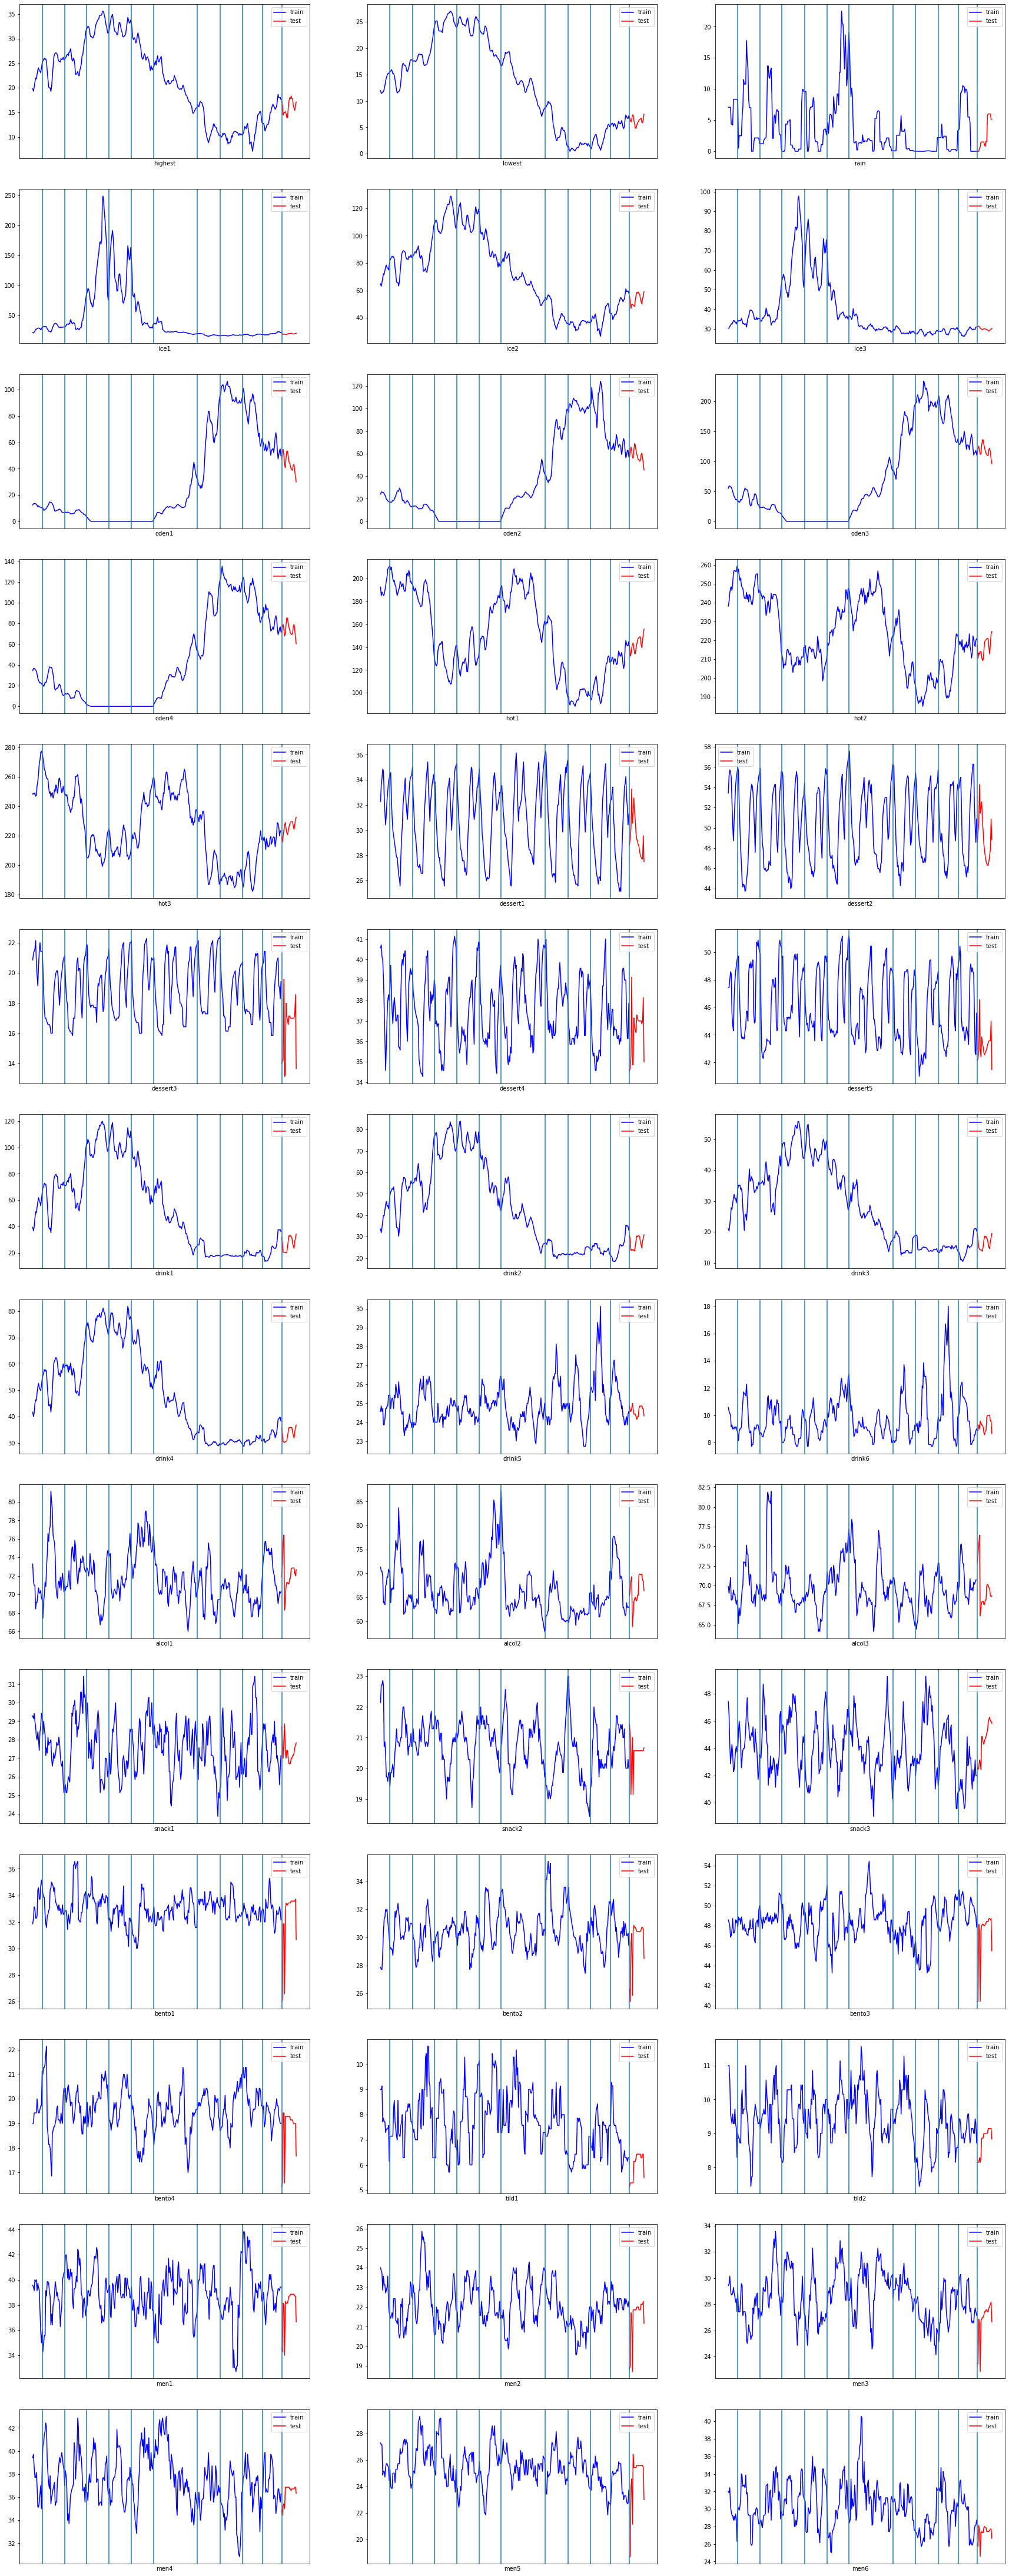

In [31]:
# 目視確認
plot_col = [c for c in train_df.columns if c not in ['id', 'date', 'time', 'year', 'month', 'day', 'weekday']]
ncols = len(plot_col) // 13
plt.subplots(14, ncols, sharey=True, sharex=True, figsize=(30, 80))
for i, col in enumerate(plot_col):
    plt.subplot(14, ncols, i+1)
    plt.plot(train_rolling.index[window:], train_rolling[col][window:], alpha=1, color='blue', label='train')
    plt.plot(all_rolling.index[-len(test_rolling):], all_rolling[col][-len(test_rolling):], alpha=1, color='red', label='test')
    for x in [20,51,81,112,143,173.204,234,265,296,324,350]:
        plt.axvline(x)
    plt.xlabel(col)
    plt.legend()
    plt.xticks([])
plt.show()